In [2]:
!pip install torch torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


In [4]:
!pip install networkx

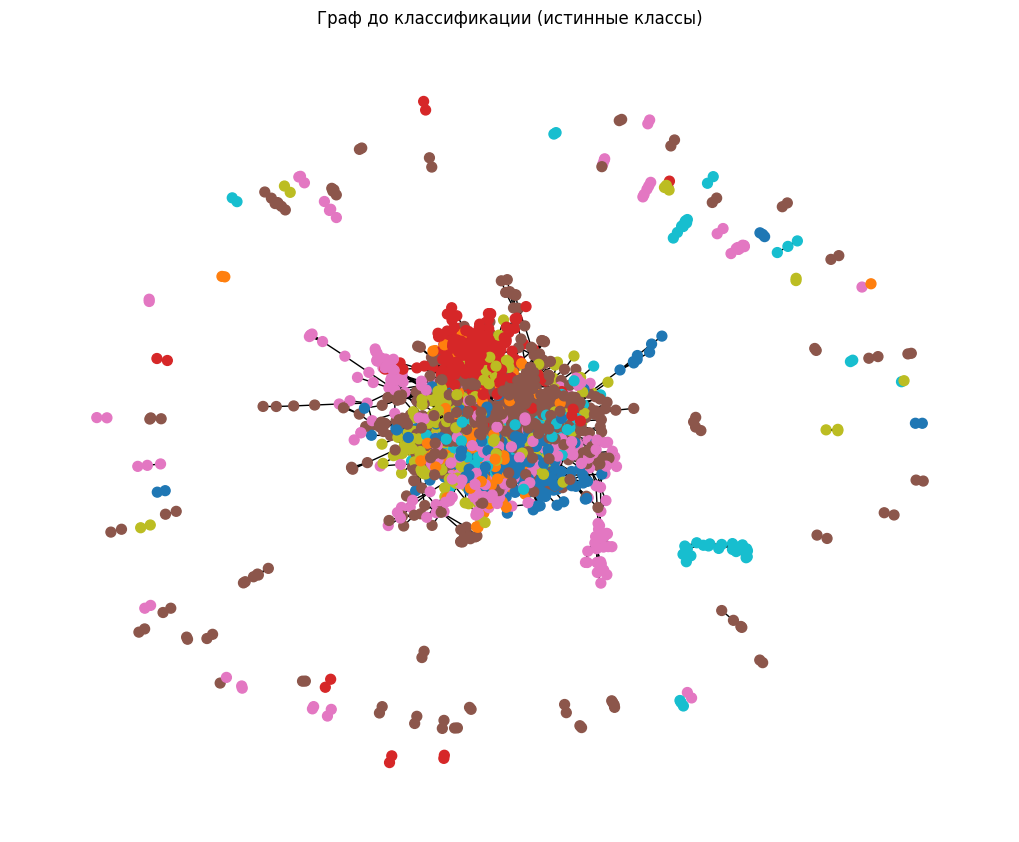

Epoch: 010, Loss: 0.8065, Train: 0.9857, Val: 0.7620, Test: 0.7940
Epoch: 020, Loss: 0.2425, Train: 0.9929, Val: 0.7680, Test: 0.8020
Epoch: 030, Loss: 0.0830, Train: 1.0000, Val: 0.7880, Test: 0.8050
Epoch: 040, Loss: 0.0790, Train: 1.0000, Val: 0.7560, Test: 0.7920
Epoch: 050, Loss: 0.0349, Train: 1.0000, Val: 0.7620, Test: 0.8020
Epoch: 060, Loss: 0.0449, Train: 1.0000, Val: 0.7520, Test: 0.8010
Epoch: 070, Loss: 0.0555, Train: 1.0000, Val: 0.7680, Test: 0.8120
Epoch: 080, Loss: 0.0373, Train: 1.0000, Val: 0.7680, Test: 0.8030
Epoch: 090, Loss: 0.0379, Train: 1.0000, Val: 0.7660, Test: 0.8060
Epoch: 100, Loss: 0.0504, Train: 1.0000, Val: 0.7700, Test: 0.8070
Epoch: 110, Loss: 0.0574, Train: 1.0000, Val: 0.7720, Test: 0.7970
Epoch: 120, Loss: 0.0340, Train: 1.0000, Val: 0.7740, Test: 0.8050
Epoch: 130, Loss: 0.0428, Train: 1.0000, Val: 0.7700, Test: 0.8040
Epoch: 140, Loss: 0.0334, Train: 1.0000, Val: 0.7720, Test: 0.8020
Epoch: 150, Loss: 0.0259, Train: 1.0000, Val: 0.7620, Test: 0.

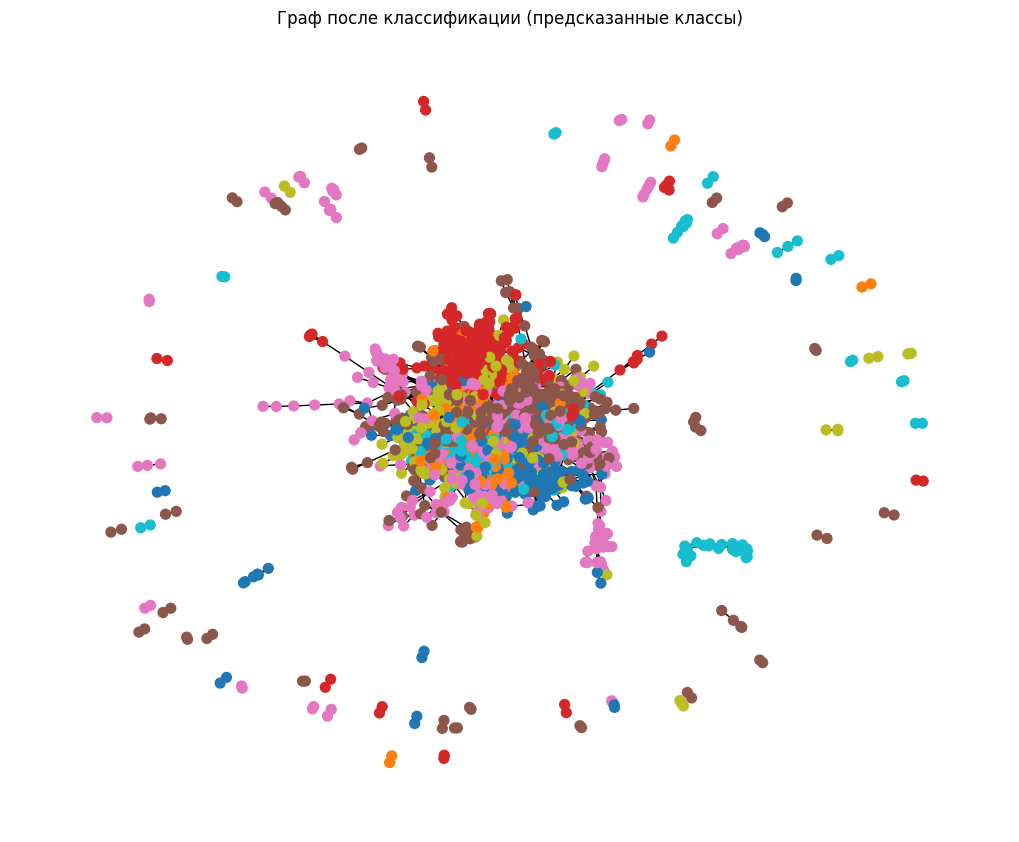

In [8]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# Загрузка датасета (например, Cora)
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]  # Берем первый (и единственный) граф из датасета

# Определение модели GCN
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Инициализация модели
model = GCN(num_features=dataset.num_features, hidden_channels=16, num_classes=dataset.num_classes)

# Оптимизатор
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Функция для обучения
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Функция для тестирования
def test():
    model.eval()
    logits, accs = model(data.x, data.edge_index), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

# Функция для визуализации графа
def visualize_graph(graph, node_color, title):
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(graph, seed=42)  # Позиционирование узлов
    nx.draw(graph, pos, node_color=node_color, with_labels=False, node_size=50, cmap=plt.cm.tab10)
    plt.title(title)
    plt.show()

# Преобразование данных в граф networkx
G = to_networkx(data, to_undirected=True)

# Визуализация до классификации
node_color_before = data.y.numpy()  # Цвета узлов по истинным классам
visualize_graph(G, node_color_before, "Граф до классификации (истинные классы)")

# Обучение модели
for epoch in range(1, 201):
    loss = train()
    if epoch % 10 == 0:
        train_acc, val_acc, test_acc = test()
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

# Визуализация после классификации
model.eval()
preds = model(data.x, data.edge_index).argmax(dim=1).numpy()  # Предсказанные классы
node_color_after = preds  # Цвета узлов по предсказанным классам
visualize_graph(G, node_color_after, "Граф после классификации (предсказанные классы)")